## 1. Import Libraries/ Dataset

a. Import the required libraries and the dataset (use Google Drive if required).

b. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [19]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import numpy as np # linear algebra
import random
from tensorflow.keras.preprocessing.text import Tokenizer # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences # to do padding or truncating
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
# mount google drive
drive.mount('./drive')

# set filepath
filepath='./drive/MyDrive/Datasets/IMDB Dataset.csv'

# load csv file in dataframe
df = pd.read_csv(filepath)
df.info()
df.head()

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 2. Data Visualization
  
a. Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text.

b. Plot a bar graph of class distribution in a dataset. Each bar depicts the number of tweets belonging to a particular sentiment. (recommended - matplotlib/seaborn libraries)

c. Any other visualizations that seem appropriate for this problem are encouraged but not necessary, for the points.

d. Print the shapes of train and test data.


 Printing sample (2) movie reivews for class:  positive
0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
Name: review, dtype: object 


 Printing sample (2) movie reivews for class:  negative
3    Basically there's a family where a little boy ...
7    This show was an amazing, fresh & innovative i...
Name: review, dtype: object 

Review shape:  (50000,)
Sentiment shape:  (50000,) 



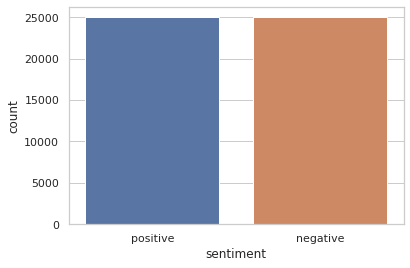

In [21]:
# print at leat two movie reviews from each class of the dataset,
# for a sanity check that labels match the text
for cls in df['sentiment'].unique():
  print('\n', 'Printing sample (2) movie reivews for class: ', cls)
  print(df[df['sentiment'] == cls]['review'].head(2), '\n')

# Plot a bar graph of class distribution in a dataset.
# Each bar depicts the number of tweets belonging to a particular sentiment.
sns.set_theme(style="whitegrid")
ax = sns.countplot(data=df, x="sentiment")

x_data = df['review']       # Reviews/Input
y_data = df['sentiment']    # Sentiment/Output

# print shape of train and test data
print('Review shape: ', x_data.shape)
print('Sentiment shape: ', y_data.shape, '\n')

## 3. Data Pre-processing

a. Need for this Step - Since the models we use cannot accept string inputs or cannot be of the string format. We have to come up with a way of handling this step. The discussion of different ways of handling this step is out of the scope of this assignment.

b. Please use this pre-trained embedding layer from TensorFlow hub for this assignment. This link also has a code snippet on how to convert a sentence to a vector. Refer to that for further clarity on this subject.

c. Bring the train and test data in the required format.

In [22]:
# pre-process review
df['review'] = df['review'].replace({'<.*?>': ''}, regex = True) # remove html tag
df['review'] = df['review'].replace({'[^A-Za-z]': ' '}, regex = True) # remove non alphabet

# encode sentiment
df['sentiment'] = df['sentiment'].replace('positive', 1)
df['sentiment'] = df['sentiment'].replace('negative', 0)

In [23]:
# split dataset
x_train = df['review'][:35000]
y_train = df['sentiment'][:35000]
x_test = df['review'][35000:]
y_test = df['sentiment'][35000:]

#Converting to Tensor
x_train_tf = tf.convert_to_tensor(x_train)
y_train_tf = tf.convert_to_tensor(y_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_test_tf = tf.convert_to_tensor(y_test)

# print training set
print('Train Set')
print(x_train, '\n')
print(y_train, '\n')

# print test set
print('Test Set')
print(x_test, '\n')
print(y_test)

Train Set
0        One of the other reviewers has mentioned that ...
1        A wonderful little production  The filming tec...
2        I thought this was a wonderful way to spend ti...
3        Basically there s a family where a little boy ...
4        Petter Mattei s  Love in the Time of Money  is...
                               ...                        
34995    Awful  Awful  Awful show   Real world  issues ...
34996    I like action movies  I have a softspot for  B...
34997    It begins on a nice note only to falter quickl...
34998    Aardman does it again  Next to Pixar  Aardman ...
34999    This movie made me laugh so much  It was a blo...
Name: review, Length: 35000, dtype: object 

0        1
1        1
2        1
3        0
4        1
        ..
34995    0
34996    0
34997    0
34998    1
34999    0
Name: sentiment, Length: 35000, dtype: int64 

Test Set
35000    Just don t bother  I thought I would see a mov...
35001    Be careful with this one  Once you get yer mit...
3

In [24]:
# funtion for resetting random seeds
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

#make some random data
reset_random_seeds()

df.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tec...,1


## 4. Model Building
a. Sequential Model layers - Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.

d. Choose the appropriate activation function for all the layers.

e. Print the model summary.

**To be done:**

Add one layer of dropout at the appropriate position and give reasons.

Choose the best number for hidden units and give reasons.

In [25]:
# set model parameters
num_batch_size = 128
num_epochs=10
#num_steps_per_epoch=274 # total training inputs/ batch size = 35000/128
#num_val_steps=118 # total validation inputs/ batch size = 15000/128
num_dropout=0.3
num_l2_reg_penalty=0.0001
num_lr=1e-4
opt = keras.optimizers.Adam(learning_rate=num_lr)
str_loss = 'binary_crossentropy'

print('Review training data shape: ', x_train.shape)
print('Sentiment training data shape: ', y_train.shape, '\n')

# import pre-trained embedding layer
#embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string)

# build model
model = keras.Sequential()
#model.add(Reshape((35000, max_length)))
model.add(hub_layer) # add layer from tensorflow hub
model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 1
model.add(Dropout(num_dropout)) # add dropout
model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 2
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 3
model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 4
model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer output

# print model summary
model.summary()

Review training data shape:  (35000,)
Sentiment training data shape:  (35000,) 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 136       
_______________________________________

## 5. Model Compilation
a. Compile the model with the appropriate loss function.

b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

c. Use accuracy as a metric.

**To be done:**

Give reasons for the choice of learning rate and its value.

In [26]:
# compile model
model.compile(optimizer = opt, loss = str_loss, metrics = ['accuracy'])

## 6. Model Training
a. Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [27]:
# checkpoint callback
checkpoint = ModelCheckpoint(
    'models/nlp.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

# early stopping callback
stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

# timing callback class
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

# timing callback
timing = TimingCallback()

# train model
history = model.fit(x_train_tf, y_train_tf, batch_size = num_batch_size, epochs = num_epochs, validation_data=(x_test_tf, y_test_tf), callbacks=[stopping, checkpoint, timing])

# total training time
print('\n', 'Total time taken for training: {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

Epoch 1/10
274/274 [==============================] - 5s 14ms/step - loss: 0.7069 - accuracy: 0.5232 - val_loss: 0.6690 - val_accuracy: 0.7039

Epoch 00001: accuracy improved from -inf to 0.57240, saving model to models/nlp.h5
Epoch 2/10
274/274 [==============================] - 4s 13ms/step - loss: 0.6473 - accuracy: 0.6889 - val_loss: 0.5265 - val_accuracy: 0.7801

Epoch 00002: accuracy improved from 0.57240 to 0.70829, saving model to models/nlp.h5
Epoch 3/10
274/274 [==============================] - 4s 13ms/step - loss: 0.5344 - accuracy: 0.7562 - val_loss: 0.4646 - val_accuracy: 0.7991

Epoch 00003: accuracy improved from 0.70829 to 0.76797, saving model to models/nlp.h5
Epoch 4/10
274/274 [==============================] - 4s 13ms/step - loss: 0.4837 - accuracy: 0.7822 - val_loss: 0.4420 - val_accuracy: 0.8103

Epoch 00004: accuracy improved from 0.76797 to 0.78591, saving model to models/nlp.h5
Epoch 5/10
274/274 [==============================] - 4s 13ms/step - loss: 0.4640 -

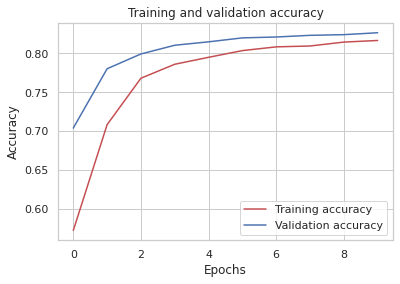

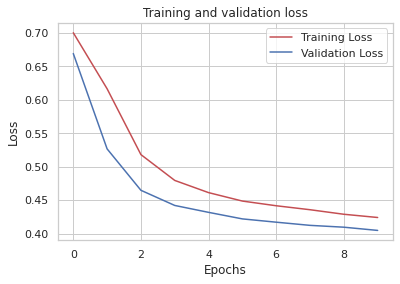

<Figure size 432x288 with 0 Axes>

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

## 7. Model Evaluation
a. Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

b. Print the two most incorrectly classified texts for each class in the test dataset.

**To be done:**

Print the two most incorrectly classified texts for each class in the test dataset.

In [29]:
# final training accuracy and loss
#print(history.history.keys())
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
print('Final Training Accuracy: {:.2f}'.format(accuracy[num_epochs-1]))
print('Final Training Loss: {:.2f}'.format(loss[num_epochs-1]))
print('Final Validation Accuracy: {:.2f}'.format(val_accuracy[num_epochs-1]))
print('Final Validation Loss: {:.2f}'.format(val_loss[num_epochs-1]))

Final Training Accuracy: 0.82
Final Training Loss: 0.42
Final Validation Accuracy: 0.83
Final Validation Loss: 0.40


In [30]:
# get predicted results
result = model.predict(x_test) # it is linear, it should be binary

# convert predicted results to binary array
y_pred = np.zeros(len(result))
for i, score in enumerate(result):
    y_pred[i] = 1 if score > 0.5 else 0

print('Predicted Sentiment: ', y_pred, '\n')

# Extract binary values from test data
y_test_val = np.zeros(len(result))
for i, score in enumerate(y_test):
    y_test_val[i] = score

print('Test Sentiment: ', y_test_val, '\n')

# confusion matrix
cm = confusion_matrix(y_test_val, y_pred, labels=[1,0])
print('Confusion Matrix', '\n', cm, '\n')

# classification report
cr = classification_report(y_test_val, y_pred, target_names=['Positive', 'Negative'])
print('Classification Report', '\n', cr)

# Analyse and report the best and worst performing class
print('The best performing class is:')
print('The worst performing lcass is:')

Predicted Sentiment:  [0. 1. 0. ... 0. 0. 0.] 

Test Sentiment:  [0. 1. 0. ... 0. 0. 0.] 

Confusion Matrix 
 [[6202 1308]
 [1296 6194]] 

Classification Report 
               precision    recall  f1-score   support

    Positive       0.83      0.83      0.83      7490
    Negative       0.83      0.83      0.83      7510

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000

The best performing class is:
The worst performing lcass is:


In [ ]:
# two most incorrectly classified texts for each class in the test dataset


**Hyperparameter Tuning**

Build two more models by changing the following hyperparameters one at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.

1. Dropout: Change the position and value of dropout layer

2. Batch Size: Change the value of batch size in model training

Write a comparison between each model and give reasons for the difference in results.


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                

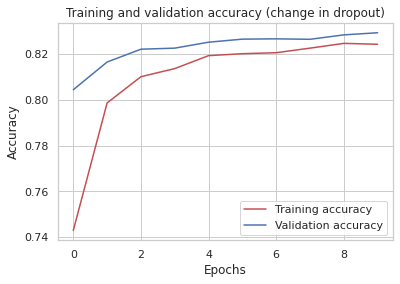

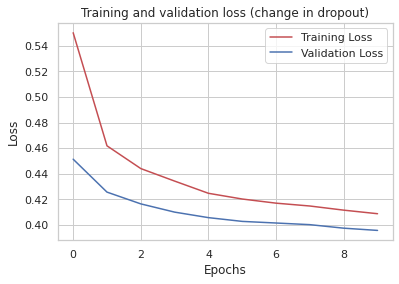

<Figure size 432x288 with 0 Axes>

In [31]:
# change the position and value of dropout layer

# model1 parameters
num_dropout1 = 0.25

# build model1
model1 = keras.Sequential()
#model.add(Reshape((35000, max_length)))
model1.add(hub_layer) # add layer from tensorflow hub
model1.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 1
model1.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 2
model1.add(Dropout(num_dropout1)) # add dropout
model1.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 3
model1.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 4
model1.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer output

# print model1 summary
model1.summary()

# compile model1
model1.compile(optimizer = opt, loss = str_loss, metrics = ['accuracy'])

# train model1
history1 = model1.fit(x_train_tf, y_train_tf, batch_size = num_batch_size, epochs = num_epochs, validation_data=(x_test_tf, y_test_tf), callbacks=[stopping, checkpoint, timing])

# total training time of model1
print('\n', 'Total time taken for training (change in dropout): {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (change in dropout)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss (change in dropout)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

In [38]:
# evaluate model1
train1_score = model1.evaluate(x_train, y_train)
print('Train Score (change in dropout) [Loss, Accuracy]: ', train1_score, '\n')
test1_score = model1.evaluate(x_test, y_test)
print('Validation Score (change in dropout) [Loss, Accuracy]: ', test1_score, '\n')

# final training accuracy and loss
#print(history.history.keys())
loss1 = history1.history['loss']
accuracy1 = history1.history['accuracy']
val1_loss = history1.history['val_loss']
val1_accuracy = history1.history['val_accuracy']
print('Final Training Accuracy (change in dropout): {:.2f}%'.format(accuracy1[num_epochs-1]*100))
print('Final Training Loss (change in dropout): {:.2f}'.format(loss1[num_epochs-1]))
print('Final Validation Accuracy (change in dropout): {:.2f}%'.format(val1_accuracy[num_epochs-1]*100))
print('Final Validation Loss (change in dropout): {:.2f}'.format(val1_loss[num_epochs-1]))

1094/1094 [==============================] - 5s 4ms/step - loss: 0.3946 - accuracy: 0.8291
Train Score (change in dropout) [Loss, Accuracy]:  [0.3945915997028351, 0.8290857076644897] 

469/469 [==============================] - 2s 4ms/step - loss: 0.3957 - accuracy: 0.8293
Validation Score (change in dropout) [Loss, Accuracy]:  [0.39567363262176514, 0.8293333053588867] 

Final Training Accuracy (change in dropout): 82.43%
Final Training Loss (change in dropout): 0.41
Final Validation Accuracy (change in dropout): 82.93%
Final Validation Loss (change in dropout): 0.40


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_45 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_47 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_48 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_49 (Dense)             (None, 1)                

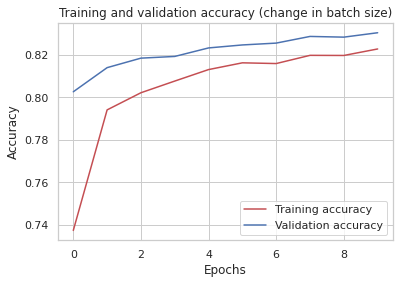

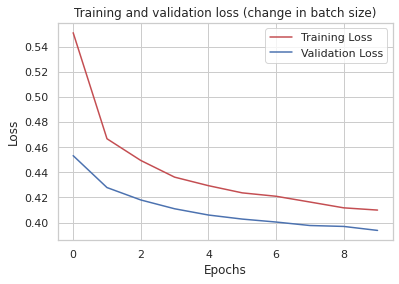

<Figure size 432x288 with 0 Axes>

In [34]:
# change the value of batch size in model training

# model2 parameters
num_batch2_size = 64

# build model2
model2 = keras.Sequential()
#model.add(Reshape((35000, max_length)))
model2.add(hub_layer) # add layer from tensorflow hub
model2.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 1
model2.add(Dropout(num_dropout)) # add dropout
model2.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 2
model2.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 3
model2.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer 4
model2.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty))) # Layer output

# print model2 summary
model2.summary()

# compile model2
model2.compile(optimizer = opt, loss = str_loss, metrics = ['accuracy'])

# train model2
history2 = model2.fit(x_train_tf, y_train_tf, batch_size = num_batch2_size, epochs = num_epochs, validation_data=(x_test_tf, y_test_tf), callbacks=[stopping, checkpoint, timing])

# total training time of model2
print('\n', 'Total time taken for training (change in batch size): {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (change in batch size)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss (change in batch size)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

In [37]:
# evaluate model2
train2_score = model2.evaluate(x_train, y_train)
print('Train Score (change in batch size) [Loss, Accuracy]: ', train2_score, '\n')
test2_score = model2.evaluate(x_test, y_test)
print('Validation Score (change in batch size) [Loss, Accuracy]: ', test2_score, '\n')

# final training accuracy and loss
#print(history.history.keys())
loss2 = history2.history['loss']
accuracy2 = history2.history['accuracy']
val2_loss = history2.history['val_loss']
val2_accuracy = history2.history['val_accuracy']
print('Final Training Accuracy (change in batch size): {:.2f}%'.format(accuracy2[num_epochs-1]*100))
print('Final Training Loss (change in batch size): {:.2f}'.format(loss2[num_epochs-1]))
print('Final Validation Accuracy (change in batch size): {:.2f}%'.format(val2_accuracy[num_epochs-1]*100))
print('Final Validation Loss (change in batch size): {:.2f}'.format(val2_loss[num_epochs-1]))

1094/1094 [==============================] - 5s 4ms/step - loss: 0.3921 - accuracy: 0.8296
Train Score (change in batch size) [Loss, Accuracy]:  [0.3920857012271881, 0.8295999765396118] 

469/469 [==============================] - 2s 4ms/step - loss: 0.3937 - accuracy: 0.8303
Validation Score (change in batch size) [Loss, Accuracy]:  [0.3937240540981293, 0.8303333520889282] 

Final Training Accuracy (change in batch size): 82.27%
Final Training Loss (change in batch size): 0.41
Final Validation Accuracy (change in batch size): 83.03%
Final Validation Loss (change in batch size): 0.39


In [ ]:
# comparison between each model